In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.processor.ljspeech import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import symbols, _symbol_to_id
from tensorflow_tts.configs import FastSpeech2Config
from tensorflow_tts.models import TFFastSpeech2

from tensorflow_tts.models import TFMelGANGenerator
from tensorflow_tts.models import TFPQMF
from tensorflow_tts.configs import MultiBandMelGANGeneratorConfig, MelGANGeneratorConfig

import IPython.display as ipd

In [2]:
!which python

/home/qblocks/anaconda3/envs/fastspeech/bin/python


### Utility Function - 

In [3]:
preTrainedModelPath = "../pretrained_model/"

rate= 22050

soundReplaySpeed = [1.6]

In [4]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
    
    input_ids = processor.text_to_sequence(input_text)
    input_ids = np.concatenate([input_ids, [len(symbols) - 1]], -1)

  # text2mel part
    if text2mel_name == "TACOTRON":
                    _, mel_after, stop_token_prediction, alignment_history = text2mel_model.inference(
                                                                    tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
                                                                    tf.convert_to_tensor([len(input_ids)], tf.int32),
                                                                    tf.convert_to_tensor([0], dtype=tf.int32)
                                                                    )
            

#                 mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
#                                                                 tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
#                                                                 attention_mask=tf.math.not_equal(tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0), 0),
#                                                                 speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
#                                                                 speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
#                                                                 f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
#                                                                 energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
#                                                                 )            
            
    elif text2mel_name == "FASTSPEECH":
        
        
                mel_before, mel_after, duration_outputs = fastspeech.inference(
                                                                input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
                                                                speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
                                                                speed_ratios=tf.convert_to_tensor(soundReplaySpeed, dtype=tf.float32),
                                                                )
#                  mel_before, mel_after, duration_outputs = text2mel_model.inference(
#                                                                  input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
#                                                                   attention_mask=tf.math.not_equal(tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0), 0),

#                                                                  speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
#                                                                  speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
#                                                                  )

    elif text2mel_name == "FASTSPEECH2":
        
               
                mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
                                                                input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
                                                                speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
                                                                speed_ratios=tf.convert_to_tensor(soundReplaySpeed, dtype=tf.float32),
                                                                f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
                                                                energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
                                                                )
        
        
#                 mel_before, mel_after, duration_outputs, _, _ = text2mel_model.inference(
#                                                                 tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
#                                                                 attention_mask=tf.math.not_equal(tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0), 0),
#                                                                 speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
#                                                                 speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
#                                                                 f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
#                                                                 energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
#                                                                 )
    else:
        raise ValueError("Only TACOTRON, FASTSPEECH, FASTSPEECH2 are supported on text2mel_name")

    
    mel_outputs = mel_after
    
    # vocoder part
    if vocoder_name == "MELGAN" or vocoder_name == "MELGAN-STFT":
        audio = vocoder_model(mel_outputs)[0, :, 0]
    elif vocoder_name == "MB-MELGAN":
        audio = vocoder_model(mel_outputs)
        audio = pqmf.synthesis(audio)[0, :, 0]
    else:
        raise ValueError("Only MELGAN, MELGAN-STFT and MB_MELGAN are supported on vocoder_name")

    if text2mel_name == "TACOTRON":
        return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
    else:
        return mel_outputs.numpy(), audio.numpy()
    
    

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

# Save to Pb

In [5]:
# mel_before, mel_after, duration_outputs, _, _ = fastspeech2.inference(
#     input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
#     attention_mask=tf.math.not_equal(tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0), 0),
#     speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
#     speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
#     f0_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
#     energy_ratios =tf.convert_to_tensor([1.0], dtype=tf.float32),
# )

In [6]:
!ls /home/qblocks/TensorFlowTTS/examples/fastspeech2/conf/fastspeech2.v2.yaml

/home/qblocks/TensorFlowTTS/examples/fastspeech2/conf/fastspeech2.v2.yaml


In [7]:
baseDir = "/home/qblocks/TensorFlowTTS/examples/"

# Load and Inference

In [8]:
!ls ../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model*

../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-10000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-100000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-15000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-20000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-25000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-30000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-35000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-40000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-41109.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-45000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-45013.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-90000.h5
../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/model-95000.h5


In [9]:
########### Loading config file for fastspeech2 model ..

with open(baseDir + "fastspeech2/conf/fastspeech2.v2.yaml") as f:
    config = yaml.load(f, Loader=yaml.Loader)
    
config = FastSpeech2Config(**config["fastspeech2_params"])
processor = LJSpeechProcessor(None, "english_cleaners")


fastspeech2 = TFFastSpeech2(config=config, name="fastspeech2")

########### load the trained model ...

# fastspeech2.load_weights("exp/train.fs2.v1/checkpoints/model-20000.h5")
fastspeech2ModelPath = "../examples/fastspeech2/exp/fs2_eng_male.v1/checkpoints/"

fastspeech2._build()
fastspeech2.load_weights( fastspeech2ModelPath + "model-30000.h5")

## Download pretrained Vocoder model


You can select one from two models. Please only run the seletected model cells.

In [10]:
# # MelGAN Original


# print("Downloading MelGAN model...")
# !gdown --id {"1A3zJwzlXEpu_jHeatlMdyPGjn1V7-9iG"} -O melgan-1M6.h5
# !gdown --id {"1Ys-twSd3m2uqhJOEiobNox6RNQf4txZs"} -O melgan_config.yml

# #  MelGAN + STFT Loss


# print("Downloading MelGAN-STFT model...")
# !gdown --id {"1WB5iQbk9qB-Y-wO8BU6S2TnRiu4VU5ys"} -O melgan.stft-2M.h5
# !gdown --id {"1OqdrcHJvtXwNasEZP7KXZwtGUDXMKNkg"} -O melgan.stft_config.yml


# # Multi-band MelGAN


# print("Downloading Multi-band MelGAN model...")
# !gdown --id {"1kChFaLI7slrTtuk3pvcOiJwJDCygsw9C"} -O mb.melgan-940k.h5
# !gdown --id {"1YC_kZpuRZGQ-JfMKj1LC0YRyKXsgLTJL"} -O mb.melgan_config.yml

In [11]:
# ####  Downloading pretrained FastSpeech model 
# print("Downloading FastSpeech model...")
# !gdown --id {"1T5GOE_M27zJlCAjnanpOS9HBPUcdE9sB"} -O fastspeech-150k.h5
# !gdown --id {"1TnkL2-rIZ6N-n4z4oHp3X2wIpxiFwu2H"} -O fastspeech_config.yml

## Load Models -

### MelGAN Original

In [12]:
# from tensorflow_tts.inference import AutoConfig
# from tensorflow_tts.inference import TFAutoModel

# trainMelGanPath = "/home/qblocks/TensorFlowTTS/examples/melgan/exp/melgan_eng_male.v1/checkpoints/" 
# # trainMelGanFile = trainMelGanPath + "generator-230000.h5"
# trainMelGanFile = trainMelGanPath + "generator-95000.h5"

# melConfigPath = "/home/qblocks/TensorFlowTTS/examples/melgan/conf/"

In [13]:
# config = AutoConfig.from_pretrained(melConfigPath + "melgan.v1.yaml")

# melgan = TFAutoModel.from_pretrained(config= config,
#                                      pretrained_path= trainMelGanFile,
#                                      is_build=True,   # don't build model if you want to save it to pb. (TF related bug)
#                                      name="melgan_generator"
#                                     )

In [28]:
with open(preTrainedModelPath + 'melgan_config.yml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

config = MelGANGeneratorConfig(**config["generator_params"])
melgan = TFMelGANGenerator(config=config, name="melgan_generator")
melgan._build()
melgan.load_weights(preTrainedModelPath + "melgan-1M6.h5")

### MelGAN STFT

In [15]:
# with open(preTrainedModelPath + 'melgan.stft_config.yml') as f:
#     config = yaml.load(f, Loader=yaml.Loader)

# config = MelGANGeneratorConfig(**config["generator_params"])
# melgan_stft = TFMelGANGenerator(config=config, name="melgan_generator")
# melgan_stft._build()
# melgan_stft.load_weights(preTrainedModelPath + "melgan.stft-2M.h5")

### Multi-band MelGAN

In [16]:
# with open(preTrainedModelPath + 'mb.melgan_config.yml') as f:
#     config = yaml.load(f, Loader=yaml.Loader)

# config = MultiBandMelGANGeneratorConfig(**config["generator_params"])
# mb_melgan = TFMelGANGenerator(config=config, name="melgan_generator")
# mb_melgan._build()
# mb_melgan.load_weights(preTrainedModelPath + "mb.melgan-940k.h5")

# # pqmf module
# pqmf = TFPQMF(config, name='pqmf')

### Input text - (test texts ) 

In [37]:
# input_text = "Bill got in the habit of asking himself 'Is that thought true?' And if he wasn’t absolutely certain it was, he just let it go."

# input_text = "There’s a way to measure the acute emotional intelligence that has never gone out of style."

# input_text = "i love you so much."

input_text = "This time the cornonavirus has spread to large number of countries and even though \
                the governments are making lot of effort, it is not clear how the growth in the number of \
                cases can be reduced and when will the planet see an overall relief from this crisis. "

### FastSpeech2 + MB-MELGAN

In [18]:
# %%time

# mels, audios = do_synthesis(input_text, fastspeech2, mb_melgan, "FASTSPEECH2", "MB-MELGAN")
# visualize_mel_spectrogram(mels[0])
# ipd.Audio(audios, rate=rate)

### FastSpeech2 + MELGAN-STFT

In [19]:
# %%time

# mels, audios = do_synthesis(input_text, fastspeech2, melgan_stft, "FASTSPEECH2", "MELGAN-STFT")
# visualize_mel_spectrogram(mels[0])
# ipd.Audio(audios, rate=rate)

### FastSpeech2 + MELGAN

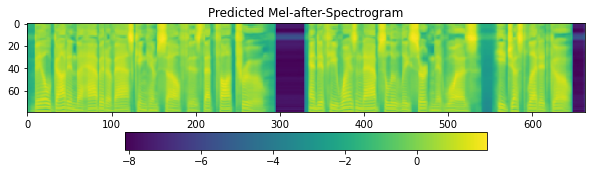

CPU times: user 4.51 s, sys: 25.7 ms, total: 4.53 s
Wall time: 4.5 s


In [29]:
%%time
mels, audios = do_synthesis(input_text, fastspeech2, melgan, "FASTSPEECH2", "MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=rate)

## Fastspeech Model - 

In [30]:
from tensorflow_tts.configs import FastSpeechConfig
from tensorflow_tts.models import TFFastSpeech

# with open('fastspeech_config.yml') as f:
#     config = yaml.load(f, Loader=yaml.Loader)

# config = FastSpeechConfig(**config["fastspeech_params"])
# fastspeech = TFFastSpeech(config=config, name="fastspeech")
# fastspeech._build()
# fastspeech.load_weights("fastspeech-150k.h5")



In [31]:
!ls ../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-*

../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-10000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-100000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-105000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-15000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-20000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-25000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-30000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-35000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-40000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-41130.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-45000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-50000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-70000.h5
../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/model-75000.h5
../examples/fastspeech/exp/fs_en

In [32]:
########### Loading config file for fastspeech2 model ..

with open('../examples/fastspeech/conf/fastspeech.v3.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)
    
config = FastSpeechConfig(**config["fastspeech_params"])
processor = LJSpeechProcessor(None, "english_cleaners")


fastspeech = TFFastSpeech(config=config, name="fastspeech")


########### load the trained model ...

fastspeechModelPath = "../examples/fastspeech/exp/fs_eng_male.v1/checkpoints/"

fastspeech._build()
fastspeech.load_weights(fastspeechModelPath + "model-75000.h5")


### FastSpeech + MB-MELGAN

In [33]:
# %%time

# mels, audios = do_synthesis(input_text, fastspeech, mb_melgan, "FASTSPEECH", "MB-MELGAN")
# visualize_mel_spectrogram(mels[0])
# ipd.Audio(audios, rate=rate)

### FastSpeech + MELGAN-STFT

In [34]:
# %%time

# mels, audios = do_synthesis(input_text, fastspeech, melgan_stft, "FASTSPEECH", "MELGAN-STFT")
# visualize_mel_spectrogram(mels[0])
# ipd.Audio(audios, rate=rate)

### FastSpeech + MELGAN

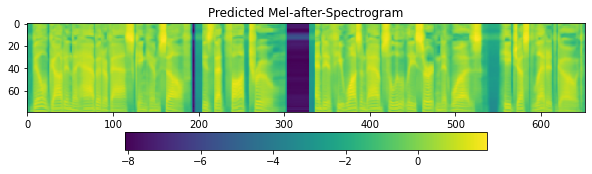

CPU times: user 2.45 s, sys: 18.1 ms, total: 2.47 s
Wall time: 2.46 s


In [35]:
%%time

mels, audios = do_synthesis(input_text, fastspeech, melgan, "FASTSPEECH", "MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=rate)

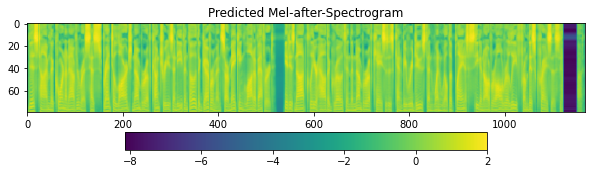

CPU times: user 254 ms, sys: 30.6 ms, total: 284 ms
Wall time: 288 ms


In [39]:
%%time

mels, audios = do_synthesis(input_text, fastspeech, melgan, "FASTSPEECH", "MELGAN")
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=rate)